<a href="https://colab.research.google.com/github/Nikit117/Skimlit-app/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Get data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
import os
filename = [data_dir+filename for filename in os.listdir(data_dir)]
filename

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

##Preprocess Data

In [ ]:
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename) 
  abstract_lines = "" 
  abstract_samples = [] 
  
  
  for line in input_lines:
    if line.startswith("###"): 
      abstract_id = line
      abstract_lines = "" 
    elif line.isspace(): 
      abstract_line_split = abstract_lines.splitlines() 


      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} 
        target_text_split = abstract_line.split("\t") 
        line_data["target"] = target_text_split[0] 
        line_data["text"] = target_text_split[1].lower() 
        line_data["line_number"] = abstract_line_number 
        line_data["total_lines"] = len(abstract_line_split) - 1 
        abstract_samples.append(line_data) 
    
    else: 
      abstract_lines += line
  
  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 824 ms, sys: 338 ms, total: 1.16 s
Wall time: 1.43 s


(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

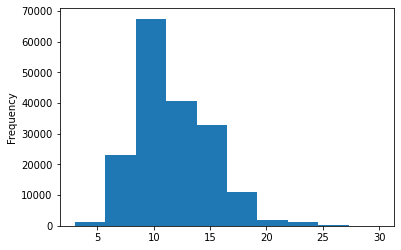

In [ ]:
train_df.total_lines.plot(kind="hist")

##Get lists of sentences

In [ ]:
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

##Make numeric labels (ML models require numeric labels)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df[["target"]])
val_labels_one_hot = one_hot_encoder.transform(val_df[["target"]])
test_labels_one_hot = one_hot_encoder.transform(test_df[["target"]])
train_labels_one_hot


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

##Label encode labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df[["target"]])
val_labels_encoded = label_encoder.transform(val_df[["target"]])
test_labels_encoded = label_encoder.transform(test_df[["target"]])
train_labels_encoded

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Creating a series of model experiments

##Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])
model_0.fit(X=train_sentences,y=train_labels_encoded);

In [ ]:
model_0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

In [ ]:

def calculate_results(y_true,y_pred):
    model_accuracy = accuracy_score(y_true,y_pred)*100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
    return model_results

In [ ]:
baseline_results = calculate_results(val_labels_encoded,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##Preparing our data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len


26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <a list of 7 Patch objects>)

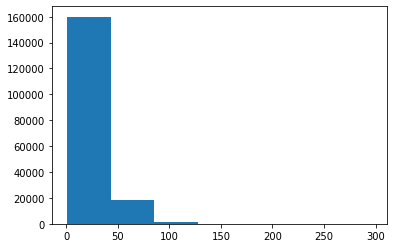

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=7)

In [ ]:
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

##Create text vectorizer

In [ ]:
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,output_sequence_length=55)


In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(target_sentence)
print(len(target_sentence.split()))
print(text_vectorizer([target_sentence]))

to our knowledge , this is the first randomized lifestyle intervention trial , which includes , besides the pregnancy period , both the prepregnancy and the postpartum period .
29
tf.Tensor(
[[   6  246  494   23   20    2  152   29  839   38   32  126 2549 4444
     2  540  173   54    2 7313    3    2 1212  173    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(len(rct_20k_text_vocab))
print(rct_20k_text_vocab[:5])
print(rct_20k_text_vocab[-5:])

64841
['', '[UNK]', 'the', 'and', 'of']
['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

##Create custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
output_dim = 128,
mask_zero=True,
name="token_embedding")
vectorized_sentence = text_vectorizer([target_sentence])
embedded_sentence = token_embed(vectorized_sentence)
print(vectorized_sentence)
print(embedded_sentence)
print(embedded_sentence.shape)

tf.Tensor(
[[   6  246  494   23   20    2  152   29  839   38   32  126 2549 4444
     2  540  173   54    2 7313    3    2 1212  173    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)
tf.Tensor(
[[[ 0.04177396 -0.00769411 -0.04880769 ... -0.02362502 -0.02025518
   -0.04621383]
  [-0.0037577   0.02534727 -0.04230416 ...  0.03456035  0.03407247
    0.04167333]
  [ 0.01065245  0.02753514 -0.00630109 ... -0.01107973  0.03508985
    0.04333449]
  ...
  [ 0.03427379  0.01328579 -0.0107276  ... -0.00805705 -0.04006469
   -0.01837476]
  [ 0.03427379  0.01328579 -0.0107276  ... -0.00805705 -0.04006469
   -0.01837476]
  [ 0.03427379  0.01328579 -0.0107276  ... -0.00805705 -0.04006469
   -0.01837476]]], shape=(1, 55, 128), dtype=float32)
(1, 55, 128)


##Create datasets (as fast as possible)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##Model 1:Conv1D with token embeddings

In [ ]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
model_1_history = model_1.fit(train_dataset,
steps_per_epoch=int(0.1*len(train_dataset)),
epochs=3,
validation_data=valid_dataset,
validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 118s 209ms/step - loss: 0.9163 - accuracy: 0.6358 - val_loss: 0.6891 - val_accuracy: 0.7360
Epoch 2/3
562/562 [==============================] - 102s 182ms/step - loss: 0.6627 - accuracy: 0.7533 - val_loss: 0.6365 - val_accuracy: 0.7709
Epoch 3/3
562/562 [==============================] - 100s 179ms/step - loss: 0.6208 - accuracy: 0.7735 - val_loss: 0.5965 - val_accuracy: 0.7872


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.5985 - accuracy: 0.7866


[0.5985440015792847, 0.7866410613059998]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[4.1345689e-01, 2.0020396e-01, 9.8202415e-02, 2.5164664e-01,
        3.6490105e-02],
       [4.1008559e-01, 3.2831421e-01, 1.3883049e-02, 2.3762745e-01,
        1.0089602e-02],
       [1.7715617e-01, 9.8313903e-03, 3.1281465e-03, 8.0979168e-01,
        9.2565453e-05],
       ...,
       [4.7643639e-06, 9.1653137e-04, 6.3121237e-04, 2.4386493e-06,
        9.9844509e-01],
       [5.2542731e-02, 4.7354752e-01, 9.5058329e-02, 7.1847394e-02,
        3.0700400e-01],
       [2.0506686e-01, 6.4165807e-01, 4.5492731e-02, 5.3863399e-02,
        5.3919032e-02]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.66410697735999,
 'precision': 0.7830562588012864,
 'recall': 0.7866410697735999,
 'f1': 0.7841499507272527}

##Model 2: Feature extraction with pretrained token embeddings

In [ ]:

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_training_sentence = random.choice(train_sentences)
print(random_training_sentence)
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(use_embedded_sentence[0][:30])
print(len(use_embedded_sentence[0]))

treatment with fdc-i/h was associated with a substantial reduction in the first and recurrent hf hospitalizations , and in total all-cause hospitalizations , reducing the total burden of costly and distressing hospitalizations .
tf.Tensor(
[-0.04350668  0.02791649  0.00375645 -0.05358031  0.02398498 -0.01820241
  0.05363278 -0.0697804   0.07922633 -0.04382077  0.06887779 -0.0387914
 -0.02924949  0.00649537  0.05674751  0.00735451 -0.07922471  0.04107945
 -0.02956939  0.0337162  -0.06991021  0.06420223  0.03171093  0.02264844
  0.01737418 -0.00213268  0.07282728 -0.05055265 -0.01249664  0.02987105], shape=(30,), dtype=float32)
512


##Building and fitting am NLP feature extraction model from TensorFlow Hub

In [ ]:
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embedding)
outputs = layers.Dense(5,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs)
model_2.compile(loss="CategoricalCrossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 21s 29ms/step - loss: 0.9174 - accuracy: 0.6490 - val_loss: 0.7955 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 15s 27ms/step - loss: 0.7685 - accuracy: 0.7026 - val_loss: 0.7529 - val_accuracy: 0.7071
Epoch 3/3
562/562 [==============================] - 14s 25ms/step - loss: 0.7498 - accuracy: 0.7133 - val_loss: 0.7357 - val_accuracy: 0.7151


In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 21s 22ms/step


array([[4.26981390e-01, 3.88973325e-01, 2.24414584e-03, 1.73419207e-01,
        8.38196650e-03],
       [3.31287444e-01, 5.43537021e-01, 3.62631446e-03, 1.18904196e-01,
        2.64497777e-03],
       [2.30107650e-01, 1.31625846e-01, 1.61884632e-02, 5.85181296e-01,
        3.68966982e-02],
       ...,
       [1.94116705e-03, 5.51257329e-03, 4.83446606e-02, 8.60532513e-04,
        9.43341136e-01],
       [4.53050621e-03, 5.07808477e-02, 2.41194397e-01, 1.44556013e-03,
        7.02048659e-01],
       [2.01501280e-01, 2.69821167e-01, 4.57667828e-01, 6.68790191e-03,
        6.43219426e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(val_labels_encoded,model_2_preds)
model_2_results

{'accuracy': 71.54772937905469,
 'precision': 0.7159309411646066,
 'recall': 0.7154772937905468,
 'f1': 0.7124666346704621}

##Model 3: Conv1D with character embeddings

##Creating a character-level tokenizer

In [ ]:
def split_chars(text):
  return " ".join(list(text))
split_chars(random_training_sentence)

't r e a t m e n t   w i t h   f d c - i / h   w a s   a s s o c i a t e d   w i t h   a   s u b s t a n t i a l   r e d u c t i o n   i n   t h e   f i r s t   a n d   r e c u r r e n t   h f   h o s p i t a l i z a t i o n s   ,   a n d   i n   t o t a l   a l l - c a u s e   h o s p i t a l i z a t i o n s   ,   r e d u c i n g   t h e   t o t a l   b u r d e n   o f   c o s t l y   a n d   d i s t r e s s i n g   h o s p i t a l i z a t i o n s   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])


t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

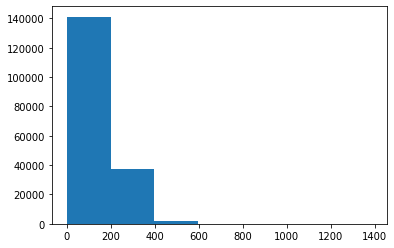

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7)

In [ ]:
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
import string
alphabet = string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet)+2
print(NUM_CHAR_TOKENS)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

70


In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))
print(char_vocab[:5])
print(char_vocab[-5:])

28
['', '[UNK]', 'e', 't', 'i']
['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(random_train_chars)
print(len(random_train_chars.split()))
vectorized_chars = char_vectorizer([random_train_chars])
print(vectorized_chars)
print(len(vectorized_sentence[0]))

s t a t i s t i c a l   a n a l y s i s   w a s   p e r f o r m e d   u s i n g   w i l c o x o n   s i g n e d - r a n k   t e s t   t o   c o m p a r e   d a s s   s c a l e s   a n d   g h q - @   s c o r e s   b e f o r e   a n d   a f t e r   a c u p r e s s u r e   i n t e r v e n t i o n   .
130
tf.Tensor(
[[ 9  3  5  3  4  9  3  4 11  5 12  5  6  5 12 19  9  4  9 20  5  9 14  2
   8 17  7  8 15  2 10 16  9  4  6 18 20  4 12 11  7 24  7  6  9  4 18  6
   2 10  8  5  6 23  3  2  9  3  3  7 11  7 15 14  5  8  2 10  5  9  9  9
  11  5 12  2  9  5  6 10 18 13 26  9 11  7  8  2  9 22  2 17  7  8  2  5
   6 10  5 17  3  2  8  5 11 16 14  8  2  9  9 16  8  2  4  6  3  2  8 21
   2  6  3  4  7  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0

##Creating a character-level embedding

In [ ]:
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS,
                              output_dim = 25,
                              mask_zero=False,
                              name="char_embed")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(char_embed_example)
print(char_embed_example.shape)

tf.Tensor(
[[[ 0.04891114  0.04855208 -0.04815381 ...  0.04185828  0.00917067
    0.01237018]
  [ 0.03727281  0.01379163 -0.02980639 ... -0.03731021 -0.00387195
    0.00366405]
  [ 0.01647881  0.02002976  0.04965721 ...  0.00800246 -0.02184633
    0.03229776]
  ...
  [ 0.04119799  0.00123143  0.00182339 ...  0.02216509 -0.02603331
    0.03515314]
  [ 0.04119799  0.00123143  0.00182339 ...  0.02216509 -0.02603331
    0.03515314]
  [ 0.04119799  0.00123143  0.00182339 ...  0.02216509 -0.02603331
    0.03515314]]], shape=(1, 290, 25), dtype=float32)
(1, 290, 25)


##Buidling a 

In [ ]:
inputs = layers.Input(shape=(1,),dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,kernel_size=5, padding="same",activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs,name="model_3_conv1d_char_embed")
model_3.compile(loss="CategoricalCrossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)   

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
mode_3_history = model_3.fit(train_char_dataset,
                             steps_per_epoch=int(0.1*len(train_char_dataset)),epochs=3,validation_data=val_char_dataset,validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 36s 63ms/step - loss: 1.2658 - accuracy: 0.4864 - val_loss: 1.0503 - val_accuracy: 0.5921
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 1.0159 - accuracy: 0.5996 - val_loss: 0.9446 - val_accuracy: 0.6287
Epoch 3/3
562/562 [==============================] - 31s 55ms/step - loss: 0.9350 - accuracy: 0.6363 - val_loss: 0.8766 - val_accuracy: 0.6699


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.8980 - accuracy: 0.6535


[0.8980127573013306, 0.6535482406616211]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 15s 16ms/step


array([[0.08151318, 0.44576615, 0.08694356, 0.31438217, 0.07139485],
       [0.21838418, 0.5269366 , 0.01626986, 0.19786955, 0.04053975],
       [0.12269593, 0.519076  , 0.13114204, 0.17937692, 0.0477091 ],
       ...,
       [0.02330504, 0.05712264, 0.12471806, 0.04837471, 0.7464796 ],
       [0.020449  , 0.10524262, 0.39796618, 0.0328796 , 0.4434626 ],
       [0.18758056, 0.66370505, 0.02963316, 0.10323602, 0.01584527]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded,model_3_preds)

In [ ]:
model_3_results

{'accuracy': 65.35482589699457,
 'precision': 0.6490246339719226,
 'recall': 0.6535482589699457,
 'f1': 0.6461195260425152}

In [ ]:

token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)


char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])


combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) 
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)


model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

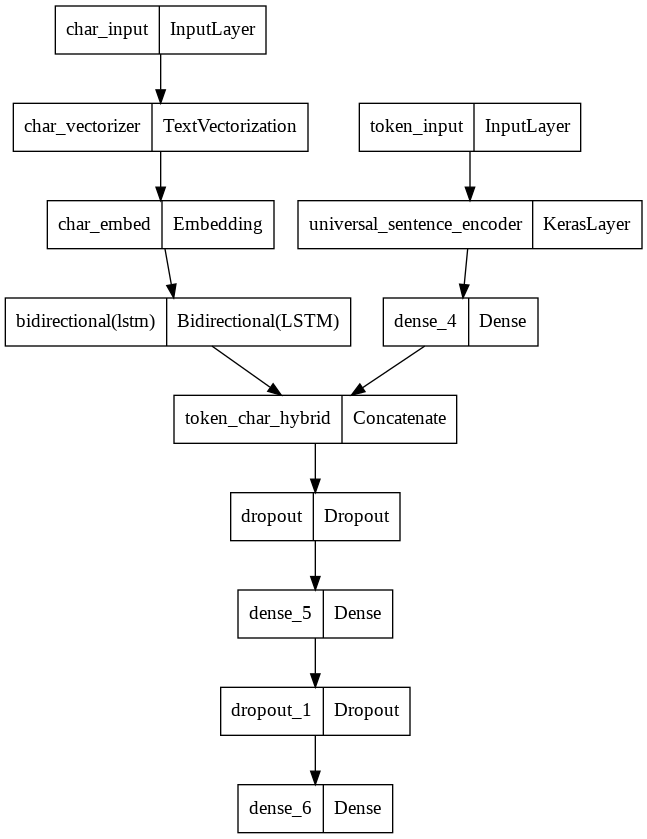

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
model_4.compile(loss="CategoricalCrossentropy",optimizer="Adam",metrics=["accuracy"])

In [ ]:

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) 
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 


train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:

model_4_history = model_4.fit(train_char_token_dataset, 
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 238s 413ms/step - loss: 0.9723 - accuracy: 0.6120 - val_loss: 0.7804 - val_accuracy: 0.7015
Epoch 2/3
562/562 [==============================] - 232s 413ms/step - loss: 0.7950 - accuracy: 0.6931 - val_loss: 0.7211 - val_accuracy: 0.7274
Epoch 3/3
562/562 [==============================] - 209s 373ms/step - loss: 0.7732 - accuracy: 0.7011 - val_loss: 0.6913 - val_accuracy: 0.7404


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 100s 106ms/step - loss: 0.6963 - accuracy: 0.7322


[0.6963391900062561, 0.7321925163269043]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 102s 106ms/step


array([[4.1866329e-01, 3.5042670e-01, 2.1600591e-03, 2.2338398e-01,
        5.3659803e-03],
       [3.7317473e-01, 4.0886456e-01, 1.9788216e-03, 2.1425541e-01,
        1.7265045e-03],
       [2.8547427e-01, 9.4146952e-02, 2.8677108e-02, 5.6602287e-01,
        2.5678672e-02],
       ...,
       [3.4330788e-04, 7.9705771e-03, 5.0516080e-02, 1.2003221e-04,
        9.4104999e-01],
       [7.0199389e-03, 5.4990850e-02, 2.4833232e-01, 3.4180051e-03,
        6.8623894e-01],
       [2.7989736e-01, 3.7229413e-01, 2.8047633e-01, 2.2607807e-02,
        4.4724338e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(val_labels_encoded,model_4_preds)
model_4_results

{'accuracy': 73.21925062888918,
 'precision': 0.7319684716564298,
 'recall': 0.7321925062888919,
 'f1': 0.7292686278533232}

In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

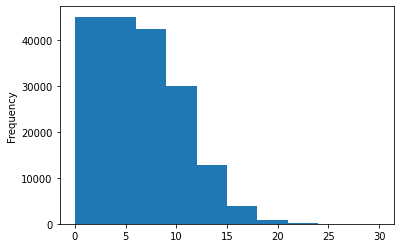

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth = 15)


In [ ]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

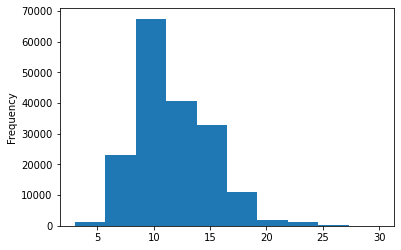

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines,98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [ ]:
token_inputs = layers.Input(shape=[],dtype="string",name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,),dtype=tf.int32,name="line_number_input")
x = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,outputs=x)

total_lines_inputs = layers.Input(shape=(20,),dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32,activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,outputs=y)

combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,char_model.output])

z = layers.Dense(256,activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate(name="token_char_postitonal_embedding")([line_number_model.output,
                                                               total_line_model.output,z])
output_layer = layers.Dense(5,activation="softmax",name="output_layer")(z)

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)


In [ ]:
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

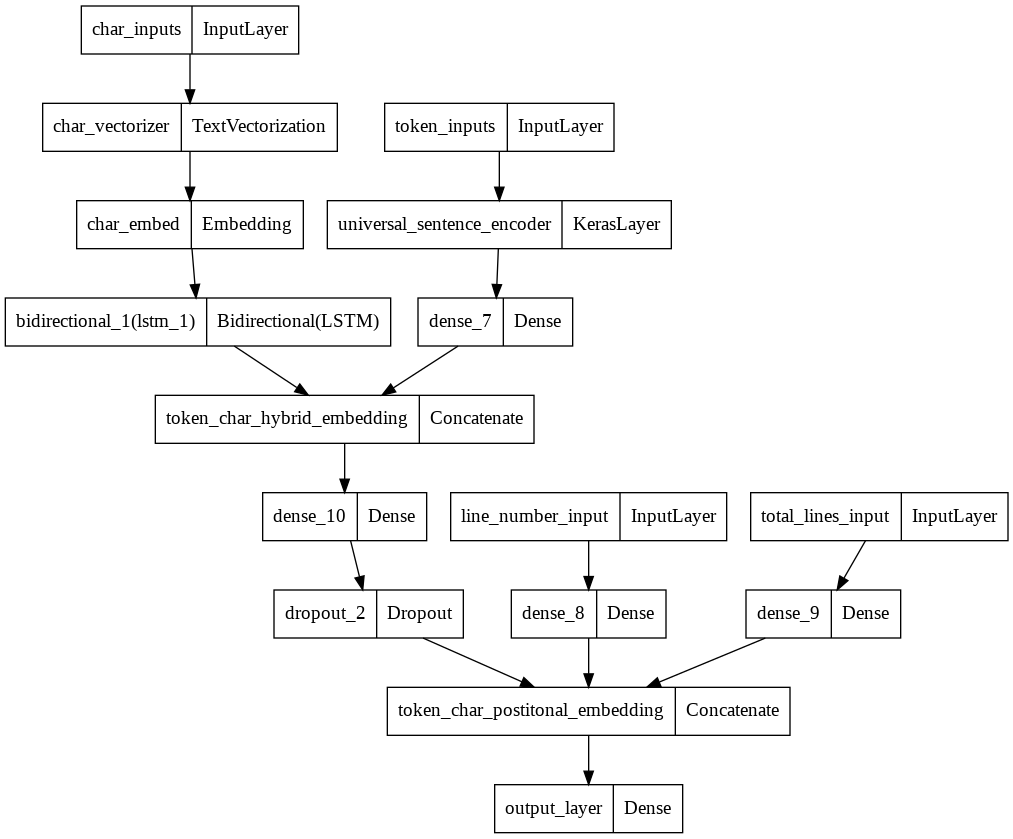

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
for layers in model_5.layers:
  print(layers,layers.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa688a74ed0> True
<keras.engine.input_layer.InputLayer object at 0x7fa67be31650> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fa681256210> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fa688c1f290> False
<keras.layers.core.embedding.Embedding object at 0x7fa6812723d0> True
<keras.layers.core.dense.Dense object at 0x7fa67be31950> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7fa67bc21950> True
<keras.layers.merging.concatenate.Concatenate object at 0x7fa67baf14d0> True
<keras.engine.input_layer.InputLayer object at 0x7fa67bc28c50> True
<keras.engine.input_layer.InputLayer object at 0x7fa67bc65fd0> True
<keras.layers.core.dense.Dense object at 0x7fa67baa7890> True
<keras.layers.core.dense.Dense object at 0x7fa67bc405d0> True
<keras.layers.core.dense.Dense object at 0x7fa67bb6ed50> True
<keras.layers.regularization.dropout.Dropout object at 0x7fa68717a890> True
<keras.layers

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="Adam",
                metrics=["accuracy"])


In [ ]:

train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                train_total_lines_one_hot, 
                                                                train_sentences,
                                                                train_chars)) 
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) 
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 227s 391ms/step - loss: 1.0967 - accuracy: 0.7275 - val_loss: 0.9836 - val_accuracy: 0.8075
Epoch 2/3
562/562 [==============================] - 222s 395ms/step - loss: 0.9662 - accuracy: 0.8166 - val_loss: 0.9514 - val_accuracy: 0.8308
Epoch 3/3
562/562 [==============================] - 212s 377ms/step - loss: 0.9491 - accuracy: 0.8240 - val_loss: 0.9369 - val_accuracy: 0.8331


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset,verbose=1)
model_5_pred_probs

945/945 [==============================] - 110s 113ms/step


array([[0.49718302, 0.10983824, 0.01104849, 0.3604588 , 0.02147147],
       [0.5359289 , 0.09688952, 0.04922896, 0.305683  , 0.01226973],
       [0.26826185, 0.11509243, 0.13867971, 0.41288102, 0.06508497],
       ...,
       [0.03072281, 0.08258067, 0.04048001, 0.02674386, 0.8194727 ],
       [0.03065109, 0.26455516, 0.08241167, 0.02626219, 0.5961199 ],
       [0.3292982 , 0.46949616, 0.09479813, 0.05133911, 0.05506843]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded,model_5_preds)
model_5_results

{'accuracy': 83.30133721699987,
 'precision': 0.8320858245620489,
 'recall': 0.8330133721699987,
 'f1': 0.8319490033296953}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.664107,0.783056,0.786641,0.784150
pretrained_token_embed,71.547729,0.715931,0.715477,0.712467
custom_char_embed_conv1d,65.354826,0.649025,0.653548,0.646120
hybrid_char_token_embed,73.219251,0.731968,0.732193,0.729269
tribrid_pos_char_token_embed,83.301337,0.832086,0.833013,0.831949


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

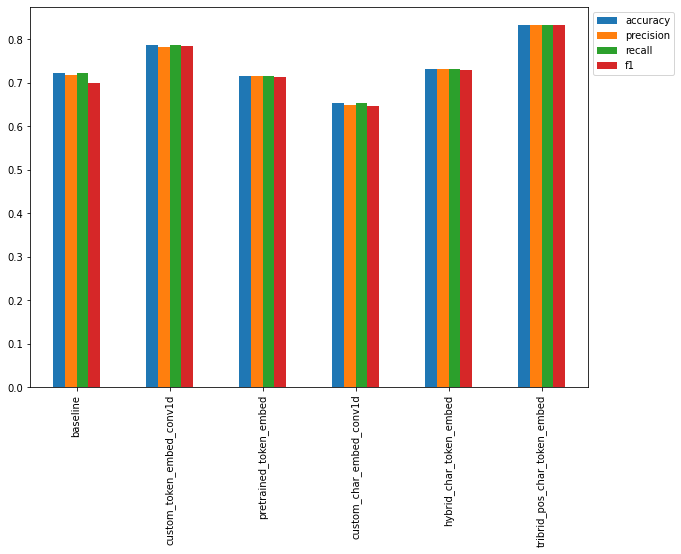

In [ ]:
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

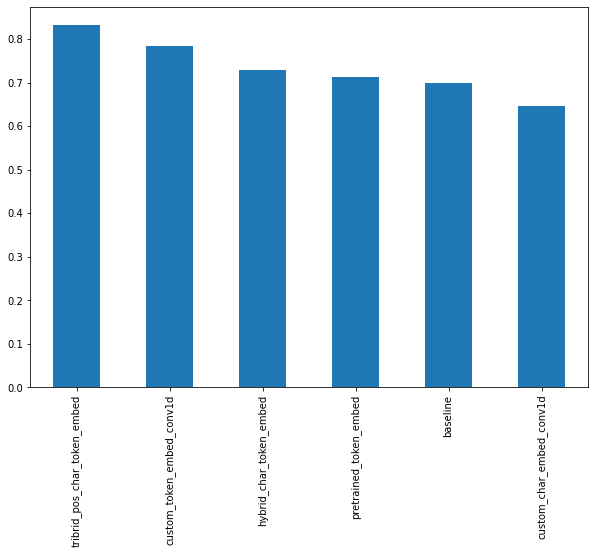

In [ ]:
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

In [ ]:
model_5.save("skimlit_tribid_model")

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:

test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 98s 104ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results


{'accuracy': 82.87373485979758,
 'precision': 0.8273189171795692,
 'recall': 0.8287373485979758,
 'f1': 0.8275103049857502}

In [ ]:
%%time

test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 7.38 s, sys: 71.5 ms, total: 7.45 s
Wall time: 8.46 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',


In [ ]:

test_df["prediction"] = test_pred_classes 
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() 
test_df["correct"] = test_df["prediction"] == test_df["target"] 
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.455745,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.345563,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.834579,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.671027,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.681894,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.859761,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.514654,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.502772,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.444210,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.577643,True


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
import json
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)
example_abstracts

--2022-11-05 07:07:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.4’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-11-05 07:07:23 (59.1 MB/s) - ‘skimlit_example_abstracts.json.4’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:

abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
!pip3 install simplejson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 5.1 MB/s 


In [ ]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
import spacy
from spacy.lang.en import English
nlp = English() # setup English sentence parser
# sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe('sentencizer') # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
%%time
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step
CPU times: user 2.21 s, sys: 52.1 ms, total: 2.26 s
Wall time: 2.38 s


array([[0.3202686 , 0.10487022, 0.01704466, 0.5337986 , 0.02401799],
       [0.08434079, 0.02930891, 0.7243844 , 0.10350349, 0.0584624 ],
       [0.13576052, 0.04429723, 0.5085927 , 0.20109664, 0.11025288],
       [0.1058982 , 0.13575064, 0.5616788 , 0.08147297, 0.11519925],
       [0.06457902, 0.09233762, 0.40917248, 0.05188451, 0.38202637],
       [0.03598185, 0.10324518, 0.599359  , 0.04423988, 0.2171741 ],
       [0.03714138, 0.1562872 , 0.07273038, 0.02764923, 0.7061917 ],
       [0.0217588 , 0.11829449, 0.30748945, 0.03276365, 0.5196936 ]],
      dtype=float32)

In [ ]:

test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
